In [1]:
#Importing a few libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import sklearn
import seaborn as sns
import time
from sklearn.tree import plot_tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.utils import class_weight

RANDOM_STATE_SEED = 12

# I. Data Analysis

In [2]:
#Read data from parquet files
df1_dataset = pd.read_parquet("DDoS1-Tuesday-20-02-2018_TrafficForML_CICFlowMeter.parquet")
df2_dataset = pd.read_parquet("DDoS2-Wednesday-21-02-2018_TrafficForML_CICFlowMeter.parquet")

In [3]:
# Concatenate df1_dataset and df2_dataset along axis 0 (row-wise)
df_dataset = pd.concat([df1_dataset, df2_dataset], axis=0)

In [4]:
#Display data
df_dataset

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,6,888751,11,11,1249,1969,736,0,113.545456,220.896072,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
1,0,112642816,3,0,0,0,0,0,0.000000,0.000000,...,0,0.0,0.0,0,0,56300000.0,7.071068,56300000,56300000,Benign
2,0,112642712,3,0,0,0,0,0,0.000000,0.000000,...,0,0.0,0.0,0,0,56300000.0,18.384777,56300000,56300000,Benign
3,0,112642648,3,0,0,0,0,0,0.000000,0.000000,...,0,0.0,0.0,0,0,56300000.0,5.656854,56300000,56300000,Benign
4,0,112642702,3,0,0,0,0,0,0.000000,0.000000,...,0,0.0,0.0,0,0,56300000.0,65.053825,56300000,56300000,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561391,6,1252,5,2,935,274,935,0,187.000000,418.144714,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
561392,6,19055,5,2,935,341,935,0,187.000000,418.144714,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
561393,6,36677,5,2,935,341,935,0,187.000000,418.144714,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
561394,6,1849,5,2,935,341,935,0,187.000000,418.144714,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign


In [5]:
# Replace +ve and -ve infinity with NaN
df_dataset.replace([np.inf, -np.inf], np.nan, inplace=True)

In [6]:
# Drop rows with null values
df_dataset.dropna(inplace=True)

In [7]:
df_dataset.isnull().sum()

Protocol                    0
Flow Duration               0
Total Fwd Packets           0
Total Backward Packets      0
Fwd Packets Length Total    0
                           ..
Idle Mean                   0
Idle Std                    0
Idle Max                    0
Idle Min                    0
Label                       0
Length: 78, dtype: int64

In [8]:
# Descriptive statistics of dataset
df_dataset.describe()

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Fwd Act Data Packets,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,1.516242e+06,1.516242e+06,1.516242e+06,1.516242e+06,1.516242e+06,1.516242e+06,1.516242e+06,1.516242e+06,1.516242e+06,1.516242e+06,...,1.516242e+06,1.516242e+06,1.516242e+06,1.516242e+06,1.516242e+06,1.516242e+06,1516242.0,1.516242e+06,1.516242e+06,1.516242e+06
mean,6.869231e+00,9.064749e+06,1.971200e+02,4.625881e+00,6.545791e+03,3.133920e+03,3.124259e+02,3.525636e+00,7.047224e+01,1.377741e+02,...,1.939113e+02,1.892650e+01,2.745230e+04,1.353791e+04,4.907409e+04,1.950246e+04,5236406.5,6.234499e+04,5.299285e+06,5.175039e+06
std,3.057031e+00,2.209509e+07,4.968769e+03,1.198103e+02,1.589931e+05,1.737952e+05,3.877777e+02,1.513306e+01,7.781921e+01,1.709302e+02,...,4.968674e+03,3.596368e+00,3.616128e+05,1.745244e+05,5.230418e+05,3.240248e+05,12887393.0,1.059574e+06,1.285253e+07,1.266421e+07
min,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.000000e+00,2.940000e+03,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.000000e+00,3.209230e+05,3.000000e+00,2.000000e+00,4.800000e+01,3.120000e+02,4.100000e+01,0.000000e+00,3.400000e+01,1.154701e+01,...,1.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
75%,6.000000e+00,3.441316e+06,5.000000e+00,4.000000e+00,9.350000e+02,9.640000e+02,6.770000e+02,0.000000e+00,1.435000e+02,2.281297e+02,...,1.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
max,1.700000e+01,1.200000e+08,3.096290e+05,2.151400e+04,9.908128e+06,3.130897e+07,2.224000e+03,1.443000e+03,1.458111e+03,8.407499e+02,...,3.096280e+05,4.400000e+01,7.594122e+07,2.564258e+07,7.594123e+07,7.594123e+07,119996344.0,7.089778e+07,1.199963e+08,1.199963e+08


In [9]:
# Count the occurrences of each unique value in the "Label" column
df_dataset["Label"].value_counts()

Benign                    740287
DDoS attacks-LOIC-HTTP    575364
DDOS attack-HOIC          198861
DDOS attack-LOIC-UDP        1730
Name: Label, dtype: int64

In [10]:
# Assign the DataFrame 'df_dataset' to a new variable 'df'
df = df_dataset

In [11]:
#Visualize the target feature's class distribution
from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
import plotly.express as px
init_notebook_mode(connected=True)
import plotly.graph_objs as go

fig = go.Figure(data=[
    go.Bar(name='Benign', 
           y=df["Label"].value_counts().values[0:1],
           x=['Benign'],
           text = df["Label"].value_counts()[0:1],
           orientation='v',
           textposition='outside',),
    go.Bar(name='DDoS attacks-LOIC-HTTP', 
           y=df["Label"].value_counts().values[1:2],
           x=['DDoS attacks-LOIC-HTTP '],
           text = df["Label"].value_counts()[1:2],
           orientation='v',
           textposition='outside',),
    go.Bar(name='DDOS attack-HOIC  ', 
           y=df["Label"].value_counts().values[2:3],
           x=['DDOS attack-HOIC  '],
           text = df["Label"].value_counts()[2:3],
           orientation='v',
           textposition='outside',),
    go.Bar(name='DDOS attack-LOIC-UDP', 
           y=df["Label"].value_counts().values[3:],
           x=['DDOS attack-LOIC-UDP'],
           text = df["Label"].value_counts()[3:],
           orientation='v',
           textposition='outside',)
])
# Change the bar mode
fig.update_layout(
                  width=800,
                  height=600,
                  title=f'Class Distribution',
                  yaxis_title='Number of attacks',
                  xaxis_title='Attack Name',)
iplot(fig)

In [12]:
df['Label'].unique()

array(['Benign', 'DDoS attacks-LOIC-HTTP', 'DDOS attack-LOIC-UDP',
       'DDOS attack-HOIC'], dtype=object)

In [13]:
from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder()

In [14]:
df['Label'] = le.fit_transform(df['Label'])

In [15]:
df["Label"].value_counts()

0    740287
3    575364
1    198861
2      1730
Name: Label, dtype: int64

In [16]:
df

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,6,888751,11,11,1249,1969,736,0,113.545456,220.896072,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,0
1,0,112642816,3,0,0,0,0,0,0.000000,0.000000,...,0,0.0,0.0,0,0,56300000.0,7.071068,56300000,56300000,0
2,0,112642712,3,0,0,0,0,0,0.000000,0.000000,...,0,0.0,0.0,0,0,56300000.0,18.384777,56300000,56300000,0
3,0,112642648,3,0,0,0,0,0,0.000000,0.000000,...,0,0.0,0.0,0,0,56300000.0,5.656854,56300000,56300000,0
4,0,112642702,3,0,0,0,0,0,0.000000,0.000000,...,0,0.0,0.0,0,0,56300000.0,65.053825,56300000,56300000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561391,6,1252,5,2,935,274,935,0,187.000000,418.144714,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,0
561392,6,19055,5,2,935,341,935,0,187.000000,418.144714,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,0
561393,6,36677,5,2,935,341,935,0,187.000000,418.144714,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,0
561394,6,1849,5,2,935,341,935,0,187.000000,418.144714,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,0


In [17]:
df.columns

Index(['Protocol', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Fwd Packets Length Total',
       'Bwd Packets Length Total', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Packet Length Min', 'Packet Length Max', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Count', 'RST Fla

These numerical columns in our dataset have different ranges of values, which can potentially confuse our model during training. To address this issue, we need to normalize our data.

In [18]:
min_max_scaler = MinMaxScaler().fit(df[['Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Fwd Packets Length Total',
       'Bwd Packets Length Total', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Packet Length Min', 'Packet Length Max', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count',
       'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count', 'Down/Up Ratio',
       'Avg Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size',
       'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate',
       'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate',
       'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets',
       'Subflow Bwd Bytes', 'Init Fwd Win Bytes', 'Init Bwd Win Bytes',
       'Fwd Act Data Packets', 'Fwd Seg Size Min', 'Active Mean', 'Active Std',
       'Active Max', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max',
       'Idle Min',]])

In [19]:
numerical_columns = ['Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Fwd Packets Length Total',
       'Bwd Packets Length Total', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Packet Length Min', 'Packet Length Max', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count',
       'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count', 'Down/Up Ratio',
       'Avg Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size',
       'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate',
       'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate',
       'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets',
       'Subflow Bwd Bytes', 'Init Fwd Win Bytes', 'Init Bwd Win Bytes',
       'Fwd Act Data Packets', 'Fwd Seg Size Min', 'Active Mean', 'Active Std',
       'Active Max', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max',
       'Idle Min']

In [20]:
# Apply min-max scaling to normalize the values of numerical columns in the 'train' DataFrame
df[numerical_columns] = min_max_scaler.transform(df[numerical_columns])

In [21]:
df

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,6,0.007406,0.000032,0.000511,0.000126,0.000063,0.330935,0.0,0.077872,0.262737,...,0.727273,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000,0.000000,0
1,0,0.938690,0.000006,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.469181,9.973610e-08,0.469181,0.469181,0
2,0,0.938689,0.000006,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.469181,2.593139e-07,0.469181,0.469181,0
3,0,0.938689,0.000006,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.469181,7.978888e-08,0.469181,0.469181,0
4,0,0.938689,0.000006,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.469181,9.175722e-07,0.469181,0.469181,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561391,6,0.000010,0.000013,0.000093,0.000094,0.000009,0.420414,0.0,0.128248,0.497347,...,0.454545,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000,0.000000,0
561392,6,0.000159,0.000013,0.000093,0.000094,0.000011,0.420414,0.0,0.128248,0.497347,...,0.454545,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000,0.000000,0
561393,6,0.000306,0.000013,0.000093,0.000094,0.000011,0.420414,0.0,0.128248,0.497347,...,0.454545,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000,0.000000,0
561394,6,0.000015,0.000013,0.000093,0.000094,0.000011,0.420414,0.0,0.128248,0.497347,...,0.454545,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000,0.000000,0


# II. Random Forest Classifier Model 

In [22]:
# Split the data into training and testing sets.
train, test = train_test_split(df, test_size=0.3, random_state=RANDOM_STATE_SEED)

In [23]:
# Concise summary of tranning dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1061369 entries, 533129 to 349096
Data columns (total 78 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   Protocol                  1061369 non-null  int8   
 1   Flow Duration             1061369 non-null  float64
 2   Total Fwd Packets         1061369 non-null  float64
 3   Total Backward Packets    1061369 non-null  float64
 4   Fwd Packets Length Total  1061369 non-null  float64
 5   Bwd Packets Length Total  1061369 non-null  float64
 6   Fwd Packet Length Max     1061369 non-null  float64
 7   Fwd Packet Length Min     1061369 non-null  float64
 8   Fwd Packet Length Mean    1061369 non-null  float64
 9   Fwd Packet Length Std     1061369 non-null  float64
 10  Bwd Packet Length Max     1061369 non-null  float64
 11  Bwd Packet Length Min     1061369 non-null  float64
 12  Bwd Packet Length Mean    1061369 non-null  float64
 13  Bwd Packet Length Std  

In [24]:
train.columns

Index(['Protocol', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Fwd Packets Length Total',
       'Bwd Packets Length Total', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Packet Length Min', 'Packet Length Max', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Count', 'RST Fla

In [25]:
y_train = np.array(train.pop("Label"))
X_train = train.values

print(type(X_train))
print(type(y_train))
print(X_train.shape)
print(y_train.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(1061369, 77)
(1061369,)


In [26]:
y_test = np.array(test.pop("Label")) 
X_test = test.values

print(type(X_test))
print(type(y_test))
print(X_test.shape)
print(y_test.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(454873, 77)
(454873,)


In [27]:
rf = RandomForestClassifier(
    class_weight='balanced',
    n_estimators=175,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    bootstrap=True,
    random_state=RANDOM_STATE_SEED,
)

start_time = time.time()
rf.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
print("Time training (full features):", training_time, "s")

Time training (full features): 344.90558886528015 s


In [28]:
rf

RandomForestClassifier(class_weight='balanced', n_estimators=175,
                       random_state=12)

In [29]:
predictions = rf.predict(X_test)

In [30]:
predictions

array([0, 0, 1, ..., 0, 0, 0])

In [31]:
print(f"Accuracy: {accuracy_score(y_test, predictions)* 100:.3f}%")

Accuracy: 99.931%


In [32]:
print("Classification Report for RF: \n", classification_report(le.inverse_transform(y_test), le.inverse_transform(predictions)))

Classification Report for RF: 
                         precision    recall  f1-score   support

                Benign       1.00      1.00      1.00    221955
      DDOS attack-HOIC       1.00      1.00      1.00     59654
  DDOS attack-LOIC-UDP       0.81      0.98      0.88       515
DDoS attacks-LOIC-HTTP       1.00      1.00      1.00    172749

              accuracy                           1.00    454873
             macro avg       0.95      0.99      0.97    454873
          weighted avg       1.00      1.00      1.00    454873



<Axes: >

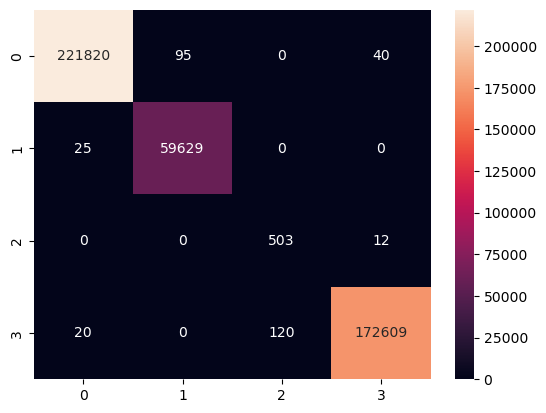

In [33]:
cf_matrix = confusion_matrix(y_test, predictions)
sns.heatmap(cf_matrix, annot=True, fmt='d')

In [34]:
import csv

# File name to save the output
filename = 'DDoS_Attack_Detection_Full_features.csv'

# Feature names
feature_names = ['Protocol', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Fwd Packets Length Total',
       'Bwd Packets Length Total', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Packet Length Min', 'Packet Length Max', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count',
       'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count', 'Down/Up Ratio',
       'Avg Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size',
       'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate',
       'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate',
       'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets',
       'Subflow Bwd Bytes', 'Init Fwd Win Bytes', 'Init Bwd Win Bytes',
       'Fwd Act Data Packets', 'Fwd Seg Size Min', 'Active Mean', 'Active Std',
       'Active Max', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max',
       'Idle Min'] 

# Class names
class_names = ['Benign', 'DDoS attacks-LOIC-HTTP', 'DDOS attack-HOIC', 'DDOS attack-LOIC-UDP']  

# Open the CSV file for writing with 'utf-8' encoding
with open(filename, 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)

    # Write the header (feature names and class names)
    writer.writerow(['Sample', 'Label'] + feature_names)

    # Write the data for each sample
    for i, label in enumerate(predictions):
        if label in [3, 1, 2]:  # Samples belonging to the DDoS classes
            features = list(X_test[i])  # Convert to a list

            # Write the data row
            row = [i, class_names[label]] + features
            writer.writerow(row)

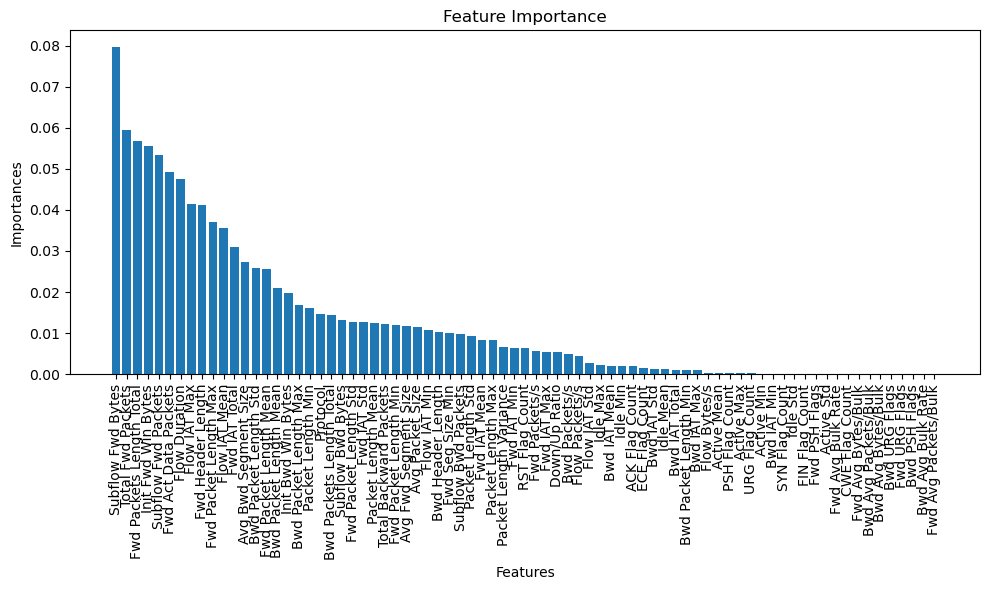

In [35]:
importance = rf.feature_importances_
feature_names = train.columns

indices = np.argsort(importance)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(train.shape[1]), importance[indices])
plt.xticks(range(train.shape[1]), feature_names[indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importances')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

# III. Training and Evaluating Model With 20 & 50 Important Features

 ### <b>  With 20 important features

In [36]:
# Retrieving indices of the 20 important features
top_20_indices = np.argsort(importance)[-20:]
# Retrieving names of the 20 important features
top_20_features = train.columns[top_20_indices]

In [37]:
# Creating a new dataset with only the 20 important features
X_train_top_20 = train[top_20_features].values
X_test_top_20 = test[top_20_features].values

In [38]:
test[top_20_features].columns

Index(['Protocol', 'Packet Length Min', 'Bwd Packet Length Max',
       'Init Bwd Win Bytes', 'Bwd Packet Length Mean',
       'Fwd Packet Length Mean', 'Bwd Packet Length Std',
       'Avg Bwd Segment Size', 'Fwd IAT Total', 'Flow IAT Mean',
       'Fwd Packet Length Max', 'Fwd Header Length', 'Flow IAT Max',
       'Flow Duration', 'Fwd Act Data Packets', 'Subflow Fwd Packets',
       'Init Fwd Win Bytes', 'Fwd Packets Length Total', 'Total Fwd Packets',
       'Subflow Fwd Bytes'],
      dtype='object')

In [39]:
rf1 = rf
rf1

start_time = time.time()
rf1.fit(X_train_top_20, y_train)
end_time = time.time()

training_time1 = end_time - start_time
print("Time training (20 features):", training_time1, "s")

Time training (20 features): 261.5557310581207 s


In [40]:
# Evaluating the performance on the test set
predictions1 = rf1.predict(X_test_top_20)
print(f"Accuracy: {accuracy_score(y_test, predictions1)* 100:.3f}%")

Accuracy: 99.964%


In [41]:
print("Classification Report for RF: \n", classification_report(le.inverse_transform(y_test), le.inverse_transform(predictions1)))

Classification Report for RF: 
                         precision    recall  f1-score   support

                Benign       1.00      1.00      1.00    221955
      DDOS attack-HOIC       1.00      1.00      1.00     59654
  DDOS attack-LOIC-UDP       0.81      0.93      0.87       515
DDoS attacks-LOIC-HTTP       1.00      1.00      1.00    172749

              accuracy                           1.00    454873
             macro avg       0.95      0.98      0.97    454873
          weighted avg       1.00      1.00      1.00    454873



<Axes: >

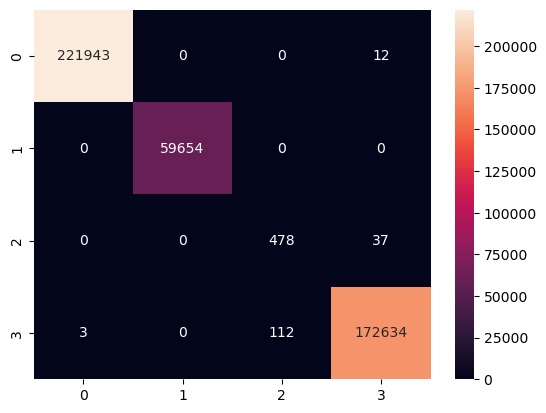

In [42]:
cf_matrix = confusion_matrix(y_test, predictions1)
sns.heatmap(cf_matrix, annot=True, fmt='d')

In [43]:
import csv

# File name to save the output
filename = 'DDoS_Attack_Detection_20_features.csv'

# Feature names
feature_names = ['Protocol', 'Packet Length Min', 'Bwd Packet Length Max',
       'Init Bwd Win Bytes', 'Bwd Packet Length Mean',
       'Fwd Packet Length Mean', 'Bwd Packet Length Std',
       'Avg Bwd Segment Size', 'Fwd IAT Total', 'Flow IAT Mean',
       'Fwd Packet Length Max', 'Fwd Header Length', 'Flow IAT Max',
       'Flow Duration', 'Fwd Act Data Packets', 'Subflow Fwd Packets',
       'Init Fwd Win Bytes', 'Fwd Packets Length Total', 'Total Fwd Packets',
       'Subflow Fwd Bytes'] 

# Class names
class_names = ['Benign', 'DDoS attacks-LOIC-HTTP', 'DDOS attack-HOIC', 'DDOS attack-LOIC-UDP']  

# Open the CSV file for writing with 'utf-8' encoding
with open(filename, 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)

    # Write the header (feature names and class names)
    writer.writerow(['Sample', 'Label'] + feature_names)

    # Write the data for each sample
    for i, label in enumerate(predictions1):
        if label in [3, 1, 2]:  # Samples belonging to the DDoS classes
            features = list(X_test_top_20[i])  # Convert to a list

            # Write the data row
            row = [i, class_names[label]] + features
            writer.writerow(row)

 ### <b>  With 50 important features

In [44]:
# Retrieving indices of the 50 important features
top_50_indices = np.argsort(importance)[-50:]
# Retrieving names of the 50 important features
top_50_features = train.columns[top_50_indices]

In [45]:
# Creating a new dataset with only the 50 important features
X_train_top_50 = train[top_50_features].values
X_test_top_50 = test[top_50_features].values

In [46]:
test[top_50_features].columns

Index(['ECE Flag Count', 'ACK Flag Count', 'Idle Min', 'Bwd IAT Mean',
       'Idle Max', 'Flow IAT Std', 'Flow Packets/s', 'Bwd Packets/s',
       'Down/Up Ratio', 'Fwd IAT Max', 'Fwd Packets/s', 'RST Flag Count',
       'Fwd IAT Min', 'Packet Length Variance', 'Packet Length Max',
       'Fwd IAT Mean', 'Packet Length Std', 'Subflow Bwd Packets',
       'Fwd Seg Size Min', 'Bwd Header Length', 'Flow IAT Min',
       'Avg Packet Size', 'Avg Fwd Segment Size', 'Fwd Packet Length Min',
       'Total Backward Packets', 'Packet Length Mean', 'Fwd IAT Std',
       'Fwd Packet Length Std', 'Subflow Bwd Bytes',
       'Bwd Packets Length Total', 'Protocol', 'Packet Length Min',
       'Bwd Packet Length Max', 'Init Bwd Win Bytes', 'Bwd Packet Length Mean',
       'Fwd Packet Length Mean', 'Bwd Packet Length Std',
       'Avg Bwd Segment Size', 'Fwd IAT Total', 'Flow IAT Mean',
       'Fwd Packet Length Max', 'Fwd Header Length', 'Flow IAT Max',
       'Flow Duration', 'Fwd Act Data Packets',

In [47]:
rf2 = rf
rf2

start_time = time.time()
rf2.fit(X_train_top_50, y_train)
end_time = time.time()

training_time2 = end_time - start_time
print("Time training (50 features):", training_time2, "s")

Time training (50 features): 394.50080394744873 s


In [48]:
# Evaluating the performance on the test set
predictions2 = rf2.predict(X_test_top_50)
print(f"Accuracy: {accuracy_score(y_test, predictions2)* 100:.3f}%")

Accuracy: 99.947%


In [49]:
print("Classification Report for RF: \n", classification_report(le.inverse_transform(y_test), le.inverse_transform(predictions2)))

Classification Report for RF: 
                         precision    recall  f1-score   support

                Benign       1.00      1.00      1.00    221955
      DDOS attack-HOIC       1.00      1.00      1.00     59654
  DDOS attack-LOIC-UDP       0.84      0.95      0.89       515
DDoS attacks-LOIC-HTTP       1.00      1.00      1.00    172749

              accuracy                           1.00    454873
             macro avg       0.96      0.99      0.97    454873
          weighted avg       1.00      1.00      1.00    454873



<Axes: >

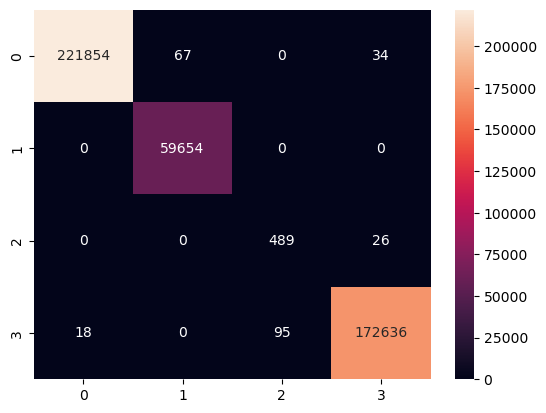

In [50]:
cf_matrix = confusion_matrix(y_test, predictions2)
sns.heatmap(cf_matrix, annot=True, fmt='d')

In [51]:
import csv

# File name to save the output
filename = 'DDoS_Attack_Detection_50_features.csv'

# Feature names
feature_names = ['ECE Flag Count', 'ACK Flag Count', 'Idle Min', 'Bwd IAT Mean',
       'Idle Max', 'Flow IAT Std', 'Flow Packets/s', 'Bwd Packets/s',
       'Down/Up Ratio', 'Fwd IAT Max', 'Fwd Packets/s', 'RST Flag Count',
       'Fwd IAT Min', 'Packet Length Variance', 'Packet Length Max',
       'Fwd IAT Mean', 'Packet Length Std', 'Subflow Bwd Packets',
       'Fwd Seg Size Min', 'Bwd Header Length', 'Flow IAT Min',
       'Avg Packet Size', 'Avg Fwd Segment Size', 'Fwd Packet Length Min',
       'Total Backward Packets', 'Packet Length Mean', 'Fwd IAT Std',
       'Fwd Packet Length Std', 'Subflow Bwd Bytes',
       'Bwd Packets Length Total', 'Protocol', 'Packet Length Min',
       'Bwd Packet Length Max', 'Init Bwd Win Bytes', 'Bwd Packet Length Mean',
       'Fwd Packet Length Mean', 'Bwd Packet Length Std',
       'Avg Bwd Segment Size', 'Fwd IAT Total', 'Flow IAT Mean',
       'Fwd Packet Length Max', 'Fwd Header Length', 'Flow IAT Max',
       'Flow Duration', 'Fwd Act Data Packets', 'Subflow Fwd Packets',
       'Init Fwd Win Bytes', 'Fwd Packets Length Total', 'Total Fwd Packets',
       'Subflow Fwd Bytes'] 

# Class names
class_names = ['Benign', 'DDoS attacks-LOIC-HTTP', 'DDOS attack-HOIC', 'DDOS attack-LOIC-UDP']  

# Open the CSV file for writing with 'utf-8' encoding
with open(filename, 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)

    # Write the header (feature names and class names)
    writer.writerow(['Sample', 'Label'] + feature_names)

    # Write the data for each sample
    for i, label in enumerate(predictions2):
        if label in [3, 1, 2]:  # Samples belonging to the DDoS classes
            features = list(X_test_top_50[i])  # Convert to a list

            # Write the data row
            row = [i, class_names[label]] + features
            writer.writerow(row)

# IV. Comparison

In [52]:
recall = recall_score(y_test, predictions, average='macro')
recall1 = recall_score(y_test, predictions1, average='macro')
recall2 = recall_score(y_test, predictions2, average='macro')

precision = precision_score(y_test, predictions, average='macro')
precision1 = precision_score(y_test, predictions1, average='macro')
precision2 = precision_score(y_test, predictions2, average='macro')

f1 = f1_score(y_test, predictions, average='macro')
f1_1 = f1_score(y_test, predictions1, average='macro')
f1_2 = f1_score(y_test, predictions2, average='macro')

accuracy = accuracy_score(y_test, predictions) 
accuracy1 = accuracy_score(y_test, predictions1) 
accuracy2 = accuracy_score(y_test, predictions2) 

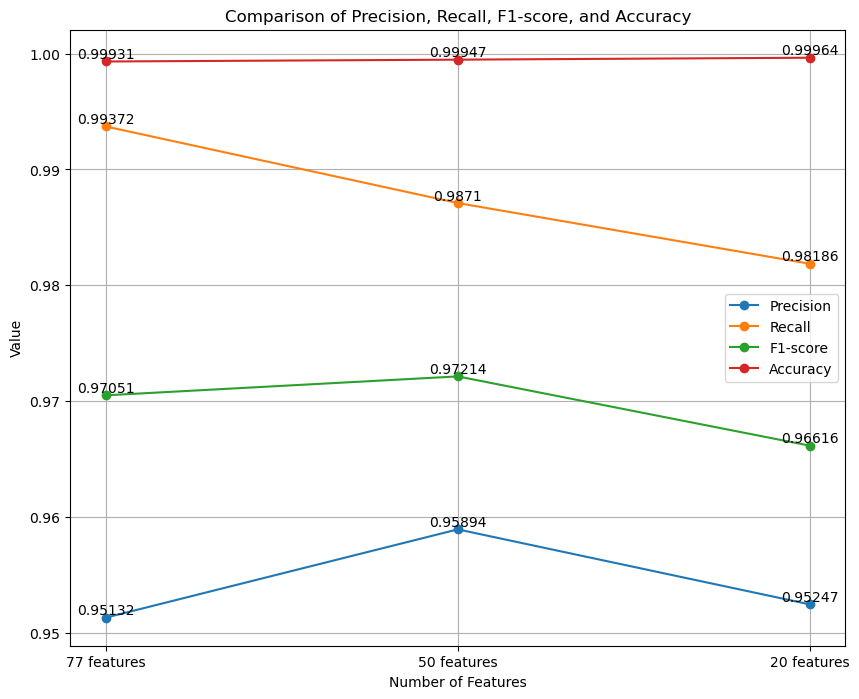

In [53]:
labels = ['77 features', '50 features', '20 features']
precisions = [precision, precision2, precision1]
recalls = [recall, recall2, recall1]
f1_scores = [f1, f1_2, f1_1]
accuracies = [accuracy, accuracy2, accuracy1]

plt.figure(figsize=(10, 8))

plt.plot(labels, precisions, marker='o', label='Precision')
plt.plot(labels, recalls, marker='o', label='Recall')
plt.plot(labels, f1_scores, marker='o', label='F1-score')
plt.plot(labels, accuracies, marker='o', label='Accuracy')

for i, val in enumerate(precisions):
    plt.text(i, val, str(round(val, 5)), ha='center', va='bottom')
for i, val in enumerate(recalls):
    plt.text(i, val, str(round(val, 5)), ha='center', va='bottom')
for i, val in enumerate(f1_scores):
    plt.text(i, val, str(round(val, 5)), ha='center', va='bottom')
for i, val in enumerate(accuracies):
    plt.text(i, val, str(round(val, 5)), ha='center', va='bottom')

plt.xlabel('Number of Features')
plt.ylabel('Value')
plt.title('Comparison of Precision, Recall, F1-score, and Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [54]:
data = {'Number of Features': labels,
        'Precision': precisions,
        'Recall': recalls,
        'F1-score': f1_scores,
       'Accuracy': accuracies}

df = pd.DataFrame(data)

In [55]:
df.set_index('Number of Features', inplace=True)

In [56]:
df

,Precision,Recall,F1-score,Accuracy
Number of Features,,,,
77 features,0.951322,0.993715,0.970510,0.999314
50 features,0.958945,0.987101,0.972142,0.999472
20 features,0.952468,0.981859,0.966162,0.999639
